In [5]:
import pandas as pd
import numpy as np
! pip install -q category_encoders # For google colab

from   category_encoders       import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.metrics         import * 
from   sklearn.preprocessing   import *
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.linear_model  import Lasso, Ridge, ElasticNet, HuberRegressor, BayesianRidge


import warnings
warnings.filterwarnings('ignore')
import joblib

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cronisterct/msds699_Final_Project_Cronister/blob/main/Final_Models.ipynb)

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/cronisterct/msds699_Final_Project_Cronister/main/NCAA_data.csv')

# Splitting Data
Split off 10% of data for test set and save for later

In [8]:
test = df.sample(frac=.1, random_state=23)

train = df[~df.index.isin(test.index)]

X = train[['SCHOOL_TYPE',
       'SPORT_CODE', 'NCAA_DIVISION', 'NCAA_SUBDIVISION',
       'NCAA_CONFERENCE', 'FOURYEAR_ATHLETES',
       'FOURYEAR_ELIGIBILITY']]
y = train['FOURYEAR_RETENTION']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.2)

# Feature Engineering

While there are no missing values in this dataset, I wanted to include Simple Imputer in my pipeline for my deployment incase someone tries to pass data that is missing a value. I wanted to use a min max scaler on the continuous data so that it was consistent and to 'pull in' outliers. Additionally, I added a one hot encoder to my preprocessing pipeline so that the categorical variables could be properly transformed for my models. 

In [9]:
categorical_columns = ['NCAA_CONFERENCE','SCHOOL_TYPE','NCAA_SUBDIVISION', 'SPORT_CODE', 'NCAA_DIVISION']
numerical_columns = ['FOURYEAR_ATHLETES', 
       'FOURYEAR_ELIGIBILITY']


con_pipe = Pipeline([('scaler', MinMaxScaler()),
                      ('imputer', SimpleImputer(strategy='median', add_indicator=True))])

cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))])

preprocessing = ColumnTransformer([('categorical', cat_pipe,  categorical_columns),
                                   ('continuous',  con_pipe, numerical_columns),
                                   ])

# Choose two algorithms

I began by picking 5 regressor algorithms we had seen in class and I wanted to pick two of them based off their MAE and MSE with no hyperparameter tuning.   

In [10]:
algorithms = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), 
               RandomForestRegressor()]

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('lm',     algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    mae = mean_absolute_error(y_validation, y_pred)
    print(f"{algo.__class__.__name__:<17} - mean squared error: {mse}")
    print(f"{algo.__class__.__name__:<17} - mean absolute error: {mae}")

LinearRegression  - mean squared error: 0.00039254409962852064
LinearRegression  - mean absolute error: 0.01396978140134215
Lasso             - mean squared error: 0.0006343952260665498
Lasso             - mean absolute error: 0.01907285484695741
Ridge             - mean squared error: 0.00039171466063605306
Ridge             - mean absolute error: 0.013959292672291491
ElasticNet        - mean squared error: 0.0006343952260665498
ElasticNet        - mean absolute error: 0.01907285484695741
RandomForestRegressor - mean squared error: 0.0004003730586684229
RandomForestRegressor - mean absolute error: 0.014328856584588275


I chose Linear Regression and Random Forest Regressor as these give us the lowest MSE and MAE without hyperparameter tuning. 

# Linear Regression

I first chose to tune a linear regression model using a random search cross validation as it is faster than a grid search while still finding optimal hyperparameters for the model. 

In [11]:
hyperparameters = {'copy_X': [True, False],
 'fit_intercept': [True, False],
 'n_jobs': [-1,1],
 'normalize': [False, True]}
lr_rand = RandomizedSearchCV(estimator=LinearRegression(), 
                              param_distributions=hyperparameters, 
                              n_iter=13, 
                              cv=5, 
                              verbose=1,
                              random_state=23)

pipe_lr_cv = Pipeline([('preprocessing', preprocessing), 
                 ('lr', lr_rand)])


pipe_lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['NCAA_CONFERENCE',
                                                   'SCHOOL_TYPE',
                                                   'NCAA_SUBDIVISION',
                                                   'SPORT_CODE',
                                                   'NCAA_DIVISION']),
                                                 ('continuous',
                       

I then get the best model that came out of the cross validation. 

In [12]:
lr_rand.best_estimator_

LinearRegression(n_jobs=-1, normalize=True)

I then wanted to display the hyperparameters that were chosen out of the cross validation step.

In [13]:
lr_rand.best_estimator_.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -1,
 'normalize': True,
 'positive': False}

I then fit this model on the data to be absolutely clear. 

In [31]:
pipe_lr = Pipeline([('preprocessing', preprocessing), 
                ('lr', LinearRegression(copy_X= True,
                                         fit_intercept= True,
                                         n_jobs= -1,
                                         normalize= True,
                                         positive= False))])
pipe_lr.fit(X,y)
y_pred_lr = pipe_lr.predict(X_validation)

I chose MAE and MSE as my test metrics because I think they give two different views of the performance of my model. While MAE gives me an idea of how off my predictions are, on average, in the scale of my y. This gives a clear and interpretable value. I also included MSE because it is another well known metric, but it also takes into account the magnitude that I am off -- i.e. I am penalized more for larger predictive mistakes. I think these metrics together give me a well rounded understanding of my models performance.

In [15]:
print('MAE', mean_absolute_error(y_validation, y_pred_lr))
print('MSE', mean_squared_error(y_validation, y_pred_lr))

MAE 0.013973454043019813
MSE 0.00039262507896591775


# Random Forest

I then chose to tune a random forest again using a random search cross validation as it is faster than a grid search while still finding optimal hyperparameters for the model.

In [16]:
hyperparameters = {'bootstrap': [True, False],
 'ccp_alpha': [0.0],
 'criterion': ['mse', 'gini'],
 'max_depth': [1, 10, 100], 
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_leaf_nodes': [10, 100, 1000],
 'max_samples': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [1, 10, 20],
 'min_samples_split': [2],
 'min_weight_fraction_leaf': [0.0],
 'n_estimators': [10, 100, 1000],
 'n_jobs': [1, -1],
 'oob_score': [False],
 'random_state': [23],
 'verbose': [0],
 'warm_start': [False, True]}
clf_rand = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                              param_distributions=hyperparameters, 
                              n_iter=13, 
                              cv=5, 
                              verbose=1)

pipe_rf_cv = Pipeline([('preprocessing',preprocessing),
                ('clf', clf_rand)])
pipe_rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['NCAA_CONFERENCE',
                                                   'SCHOOL_TYPE',
                                                   'NCAA_SUBDIVISION',
                                                   'SPORT_CODE',
                                                   'NCAA_DIVISION']),
                                                 ('continuous',
                       

I then get the best model that came out of the cross validation. 

In [17]:
clf_rand.best_estimator_

RandomForestRegressor(max_depth=10, max_leaf_nodes=1000, min_samples_leaf=20,
                      n_estimators=10, n_jobs=1, random_state=23)

I then wanted to display the hyperparameters that were chosen out of the cross validation step.

In [18]:
clf_rand.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 1000,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}

I then fit this model on the data to be absolutely clear. 

In [19]:
pipe_rf = Pipeline([('preprocessing',preprocessing),
                ('clf', RandomForestRegressor(bootstrap=True,
                                     ccp_alpha=0.0,
                                     criterion='mse',
                                     max_depth=10,
                                     max_features='auto',
                                     max_leaf_nodes=1000,
                                     max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=20,
                                     min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10,
                                     n_jobs=1,
                                     oob_score=False,
                                     random_state=23,
                                     verbose=0,
                                     warm_start=False))])

pipe_rf.fit(X,y)
y_pred_rf = pipe_rf.predict(X_validation)

I then report the metrics:

In [20]:
print('MAE', mean_absolute_error(y_validation, y_pred_rf))
print('MSE', mean_squared_error(y_validation, y_pred_rf))

MAE 0.014305298483743218
MSE 0.00040408669297835965


# Final Model

Our final model is the linear regression model as it slightly outperforms the random forest regressor across all displayed metrics. However, the validation metrics on these two algorithms were very close. I ultimately chose linear regression over random forests because of both the "better" validation metrics, and because linear models are simpler and train faster than random forests. 

In [21]:
lr_rand.best_estimator_

LinearRegression(n_jobs=-1, normalize=True)

The parameters of the final model are as follows:

In [22]:
lr_rand.best_params_

{'normalize': True, 'n_jobs': -1, 'fit_intercept': True, 'copy_X': True}

Another representation of the final model: 
- LinearRegression(copy_X=True,                   fit_intercept=True, n_jobs=-1, normalize=True, positive=False)


I then wanted to explore feature importance in the model:

In [52]:
def pretty_print(r):
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{train.columns[i]}",
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

r = permutation_importance(pipe_lr, X_validation, y_validation,
                            n_repeats=30,
                            random_state=0)
pretty_print(r)

SPORT_CODE 0.315 +/- 0.020
FOURYEAR_ELIGIBILITY 0.271 +/- 0.017
NCAA_CONFERENCE 0.088 +/- 0.009
FOURYEAR_ATHLETES 0.016 +/- 0.003
SCHOOL_TYPE 0.014 +/- 0.005
NCAA_SUBDIVISION 0.012 +/- 0.003
NCAA_DIVISION 0.001 +/- 0.001


Plot feature importance

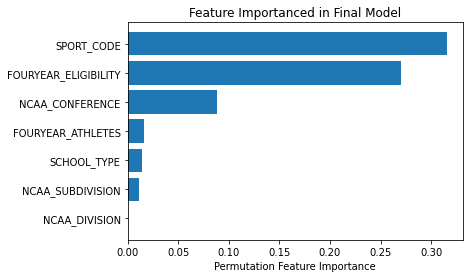

In [96]:
for_plot = pd.DataFrame(dict(zip(train.columns, r.importances_mean)), index=range(1)).T

for_plot = for_plot.sort_values(0).T

plt.barh(for_plot.columns, for_plot.iloc[0])
plt.xlabel('Permutation Feature Importance')
plt.title('Feature Importanced in Final Model')
plt.show()

Save final model for deployment.

In [24]:
joblib.dump(pipe_lr, 'lin_mod')

['lin_mod']

# Try our model on Test Data

In [25]:
X_test = test[['SCHOOL_TYPE',
       'SPORT_CODE', 'NCAA_DIVISION', 'NCAA_SUBDIVISION',
       'NCAA_CONFERENCE', 'FOURYEAR_ATHLETES', 
       'FOURYEAR_ELIGIBILITY']]
y_test = test['FOURYEAR_RETENTION']

# Test Metrics

In [26]:
test_y_lr = pipe_lr.predict(X_test)
print('MAE', mean_absolute_error(test_y_lr, y_test))
print('MSE', mean_squared_error(test_y_lr, y_test))

MAE 0.01357646692117669
MSE 0.00034432334192336246


Since the final model preforms quite similarly on the test set as the validation set, we can assume it will generalize well. Having an MAE of ~.0136 is telling us that on average, the model is off of it's prediction of retention rate by .0136 which considering the scale is from 0 to 1 makes this model useful. This work is useful as we have not only provided a model that can predict four year retention rates, but we have also provided inference on the model. Knowing that sport code and four year eligibility are the most important features of the model gives the NCAA a place to start looking into the reasons for the recent increase in transfer rates. Future work on this model would include receiving feedback from the NCAA and collecting new features that could further improve the model, such as school's academic rating.

# Summary

In this project, I began with some EDA and discovered that the dataset encoded missing values with -99. I went back through the data and replaced those values with nan. However, I wanted to create a missing category in the NCAA subdivision feature as I thought the fact is was missing could be important so I replaced those values with the word 'Missing'. From there I fit 6 models with their default hyperparameters and reported their MAE and MSE so I could choose two final models to tune and fit. This returned Linear Regression and Random Forrest Regressor as my models. From there, I used a random cv search across hyperparameters to find the best model for each algorithm. I then chose linear regression as my final model as it outperformed the random forest regressor. The final model was then tested on the test data set to see if this model is generalizable and to make sure the model did not overfit to the training data. We found that the model preformed quite well on the test dataset. I finally looked at feature importance of the final model so that I could provide some model interpretation to the NCAA. I then wrote a python script for a deployment that takes a text file with the needed features and outputs a HTML file with the predicted retention rate and how that score compares to other scores. 